In [6]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf
import wandb_util.wandb_util as wbu
from scripts.wandb_experiments.benchmark import BenchmarkConfig
import multiprocessing as mp
mp.set_start_method('spawn', force=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from scripts.wandb_experiments.benchmark import GeometryAndPrompts
from text3d2video.experiment_analysis import print_table
from text3d2video.util import concat_lists

lion_zoom = GeometryAndPrompts(
    "lion_zoom:latest",
    "lion_zoom_out_src:latest",
    ["Lion"],
    1,
)

rumba_zoom = GeometryAndPrompts(
    "rumba_zoom_20:latest",
    "rumba_zoom_out_src:latest",
    ["Deadpool", "Stormtrooper"],
    1,
)

rumba = GeometryAndPrompts(
    "rumba_20:latest",
    "human_T_front:latest",
    ["Deadpool", "Stormtrooper"],
    1
)

turn_around = GeometryAndPrompts(
    "catwalk_180_20:latest",
    'human_mv:latest',
    ["Deadpool"],
    1
)

cat_statue = GeometryAndPrompts(
    'mv_cat_statue_25:latest',
    'mv_cat_statue:latest',
    ["Metalic Cat Statue"],
    1
)

# geometries_and_promtps = [lion_zoom, rumba_zoom, rumba, turn_around, cat_statue]
geometries_and_promtps = [lion_zoom, turn_around, cat_statue]

scenes = concat_lists(s.to_scenes() for s in geometries_and_promtps)

print_table([s.tabulate_row() for s in scenes])

animation_tag            texturing_tag             prompt                seed
-----------------------  ------------------------  ------------------  ------
lion_zoom:latest         lion_zoom_out_src:latest  Lion                     0
catwalk_180_20:latest    human_mv:latest           Deadpool                 0
mv_cat_statue_25:latest  mv_cat_statue:latest      Metalic Cat Statue       0


In [8]:
from scripts.wandb_experiments.benchmark import Method
from scripts.wandb_runs.run_grtex import RunGrTexConfig, run_gr_tex
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingConfig,
)
from text3d2video.pipelines.pipeline_utils import ModelConfig
from text3d2video.utilities.omegaconf_util import (
    get_import_path,
    omegaconf_from_dotdict,
)


grtex = OmegaConf.structured(
    RunGrTexConfig(
        prompt="",
        animation_tag="",
        extr_tag="",
        generative_rendering=GenerativeRenderingConfig(),
        multires_textures=True,
        start_noise_level=0.2,
        model=ModelConfig(),
    )
)

alphas = [0.0, 0.3, 0.6, 0.8, 1.0]

configs = [
    OmegaConf.merge(
        grtex,
        omegaconf_from_dotdict({"generative_rendering.feature_blend_alpha": alpha}),
    ) for alpha in [0.0, 0.3, 0.6, 0.8, 1.0] 
]
names = [f"alpha-{alpha}" for alpha in alphas]

methods = [Method(name, get_import_path(run_gr_tex), config) for name, config in zip(names, configs)]


print_table([m.tabulate_row() for m in methods])

name       fun         config
---------  ----------  -------------------------------------------------------
alpha-0.0  run_gr_tex  prompt: ''
                       animation_tag: ''
                       extr_tag: ''
                       generative_rendering:
                         do_pre_attn_injection: true
                         do_post_attn_injection: true
                         attend_to_self_kv: true
                         mean_features_weight: 0.5
                         chunk_size: 5
                         num_inference_steps: 15
                         guidance_scale: 7.5
                         controlnet_conditioning_scale: 1.0
                         feature_blend_alpha: 0.0
                       model:
                         sd_repo: runwayml/stable-diffusion-v1-5
                         controlnet_repo: lllyasviel/control_v11f1p_sd15_depth
                       multires_textures: true
                       start_noise_level: 0.2
                  

In [11]:
from scripts.wandb_experiments.benchmark import benchmark

config = BenchmarkConfig(scenes, methods)
config = OmegaConf.structured(config)

spec = benchmark(config)

In [12]:
from scripts.wandb_experiments.benchmark import benchmark

wbu.sync_experiment(benchmark, config, "alpha_sweep")

Experiment: https://wandb.ai/romeu/diffusion-3D-features/groups/alpha_sweep/workspace
Experiment up-to-date!


In [13]:
from scripts.wandb_experiments.benchmark import split_runs

exp_name = "alpha_sweep"
print(wbu.get_exp_url(exp_name))

runs = wbu.get_logged_runs(exp_name)
texture_runs, video_gen_runs = split_runs(runs)

https://wandb.ai/romeu/diffusion-3D-features/groups/alpha_sweep/workspace


In [14]:
from text3d2video.util import group_into_array, map_array


def scene_key(run):
    config = OmegaConf.create(run.config)
    return f"{config.animation_tag}-{config.prompt}-{config.seed}"

def method_key(run):
    return run.name.split("_")[0]

runs_grouped, labels = group_into_array(video_gen_runs, [method_key, scene_key])

In [15]:
from text3d2video.experiment_analysis import VideoTraces
run_data = map_array(runs_grouped, VideoTraces.from_run, pbar=True)

 13%|█▎        | 2/15 [00:02<00:15,  1.21s/it]wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb:   20 of 20 files downloaded.  
wandb:   20 of 20 files downloaded.  mwandb: \ 1 of 20 files downloaded...
wandb:   20 of 20 files downloaded.  mwandb: \ 1 of 20 files downloaded...
wandb:   20 of 20 files downloaded.  4mwandb: \ 1 of 20 files downloaded...
wandb:   20 of 20 files downloaded.  4mwandb: \ 1 of 20 files downloaded...
100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


In [16]:
from text3d2video.utilities.video_comparison import video_grid
from text3d2video.utilities.video_util import pil_frames_to_clip

vids = map_array(run_data, lambda run: pil_frames_to_clip(run.frames))
vid = video_grid(vids)

vid.write_videofile("outs/benchmark_qual_vid.mp4")

Moviepy - Building video outs/benchmark_qual_vid.mp4.
Moviepy - Writing video outs/benchmark_qual_vid.mp4



Moviepy - Done !
Moviepy - video ready outs/benchmark_qual_vid.mp4


In [22]:
from einops import rearrange
from text3d2video.util import index_list, map_object_array, object_array, ordered_sample_indices

frame_indices = list(ordered_sample_indices(list(range(20)), 8))
ims = map_object_array(
    run_data, lambda x: object_array(index_list(x.frames, frame_indices))
)
ims = rearrange(ims, "method scene frame -> scene method frame")

alpha_indices = [0, 1, 3]
ims = ims[:, alpha_indices, :]
alpha_labels = index_list(labels[0], alpha_indices)

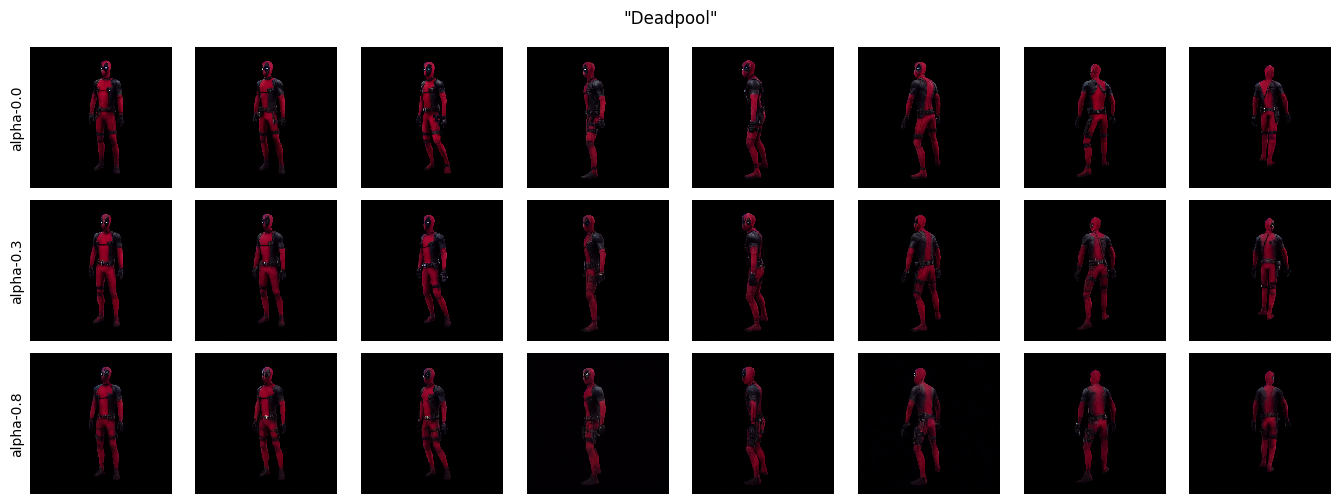

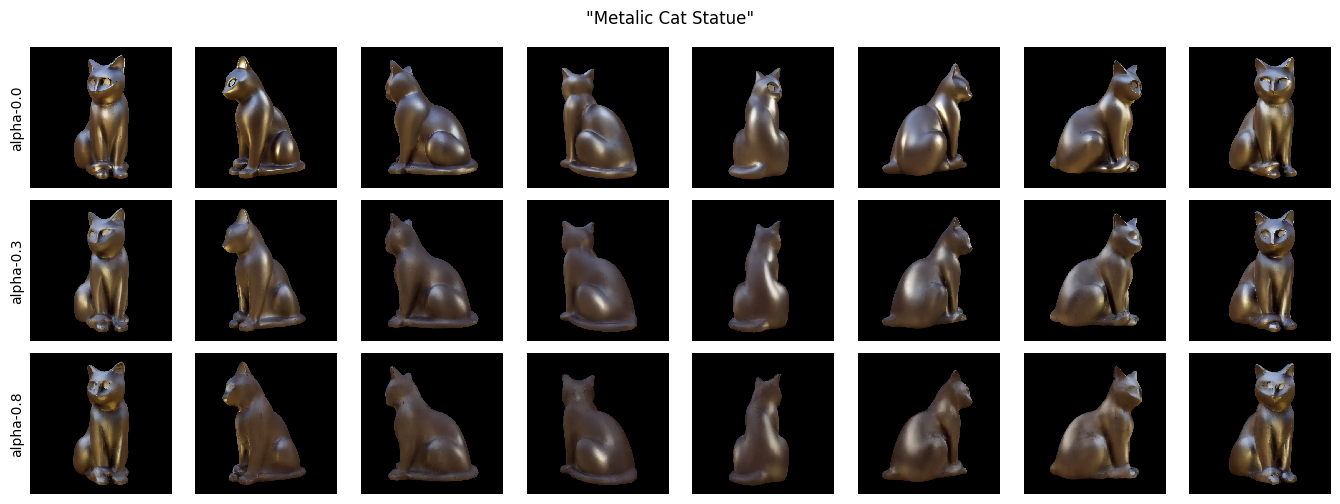

In [25]:
from matplotlib import pyplot as plt
from text3d2video.utilities.ipython_utils import display_ims_grid

fig_scene_indices = list()

# for scene_i in range(len(scene_indices)):
for scene_i in [0,2]:

    scene_run = runs_grouped[0][scene_i]
    config = OmegaConf.create(scene_run.config)
    prompt = config.prompt
    tgt_tag = config.animation_tag
    fig, axs = display_ims_grid(
        ims[scene_i],
        scale=1.7,
        row_titles=alpha_labels,
        title=f'"{prompt}"',
        show=False,
    )

    plt.savefig(f"outs/alpha_ablation/{prompt}.pdf", bbox_inches="tight", dpi=300)